In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

RANDOMSTATE = 42

np.random.seed(RANDOMSTATE)

degree = 10
datapoints = 50
num_lambdas = 30
noise = 0.5

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Setting up the data
x = np.linspace(0, 1, datapoints)
y = np.linspace(0, 1, datapoints)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)
z += noise * np.random.randn(z.shape[0], z.shape[1])
X = create_X(x, y, degree)

lambdas = np.logspace(-4, 4, num_lambdas)

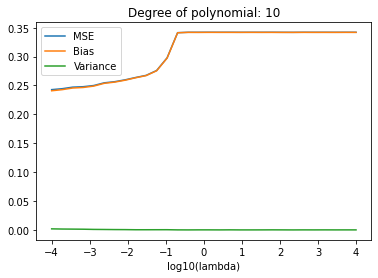

In [6]:
num_bootstraps = 50

error = np.zeros(num_lambdas)
bias = np.zeros(num_lambdas)
variance = np.zeros(num_lambdas)
i = 0

for lmb in lambdas:
    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOMSTATE)

    # every row of the matrix is a seperate prediction
    z_pred = np.zeros((z_test.shape[0], num_bootstraps))

    model = make_pipeline(StandardScaler(), Lasso(lmb, tol=0.3))

    for bootstrap in range(num_bootstraps):
        X_bootstrap, z_bootstrap = resample(X_train, z_train)

        model.fit(X_bootstrap, z_bootstrap)
        z_pred[:, bootstrap] = model.predict(X_test)
    
    #calculate errors for each degree
    bias[i] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    error[i] = bias[i] + variance[i]
    i += 1

fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), error, label='MSE')
ax.plot(np.log10(lambdas), bias, label='Bias')
ax.plot(np.log10(lambdas), variance, label='Variance')
ax.set_xlabel('log10(lambda)')
ax.set_title('Degree of polynomial: {}'.format(degree))
ax.legend()
plt.show()

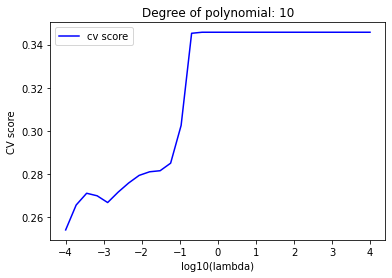

In [7]:
num_kfolds = 10
cv_score = np.zeros(num_lambdas)
cv_score_itr = 0
kfold = KFold(num_kfolds)

for lmb in lambdas:
    mse_values = np.zeros(num_kfolds)
    i = 0
    model = make_pipeline(StandardScaler(), Lasso(lmb, tol=0.3))

    cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(num_kfolds)))
    cv_score_itr += 1

fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), cv_score, 'b', label='cv score')
ax.set_xlabel('log10(lambda)')
ax.set_ylabel('CV score')
ax.set_title('Degree of polynomial: {}'.format(degree))
ax.legend()
plt.show()

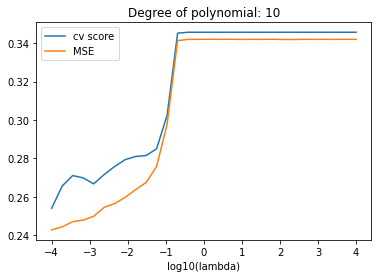

In [8]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), cv_score, label='cv score')
ax.plot(np.log10(lambdas), error, label='MSE')
ax.set_xlabel('log10(lambda)')
ax.set_title('Degree of polynomial: {}'.format(degree))
ax.legend()
plt.show()